In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
import scipy

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)

Environment specification:

python 3.10.12
numpy 1.25.2
scipy 1.11.4
seaborn 0.13.1
sklearn 1.2.2
pandas 2.0.3


### Reading CSV file as Dataframe:

In [4]:
# kaggle train data
data_df = pd.read_csv("/content/train.csv")
# kaggle test data
test_df = pd.read_csv("/content/test.csv")

In [5]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Data Analysis

**The prediction target is 'SalePrice'. Let's look closer to this column.**

In [6]:
# Basic summary:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='SalePrice'>

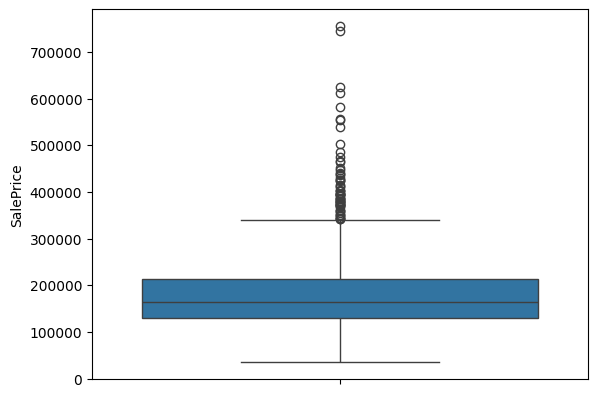

In [7]:
sns.boxplot(data_df['SalePrice'])

There are two outliers with prices more than 700000.

<Axes: xlabel='SalePrice', ylabel='Density'>

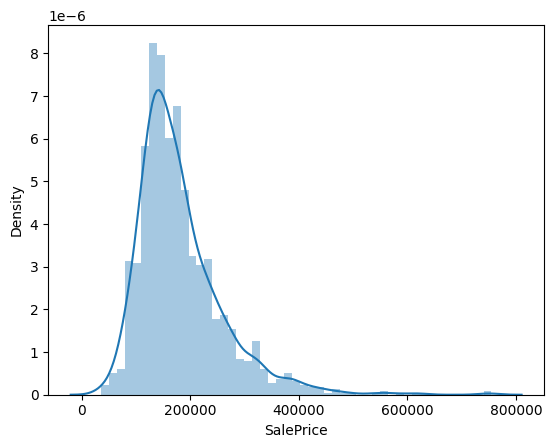

In [8]:
# Density of SalePrice
sns.distplot(data_df['SalePrice'])

I noticed that it is right-skewed distribution with the pick around 160k and quite long tail with maximum about 800k.

In [9]:
data_df['SalePrice'].skew()

1.8828757597682129

In [10]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])

Text(0.5, 1.0, 'Density of SalePrice after Log Transformation')

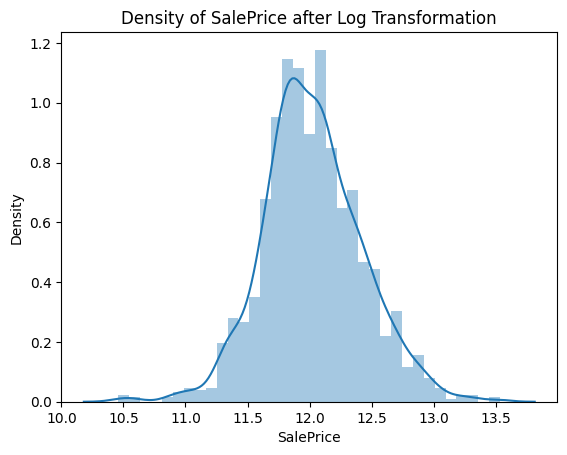

In [11]:
sns.distplot(data_df["SalePrice"])
plt.title("Density of SalePrice after Log Transformation")

In [12]:
y_train = data_df["SalePrice"]

In [13]:
#nun value checking
col_nan = data_df.isna().sum() / data_df.shape[0]

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

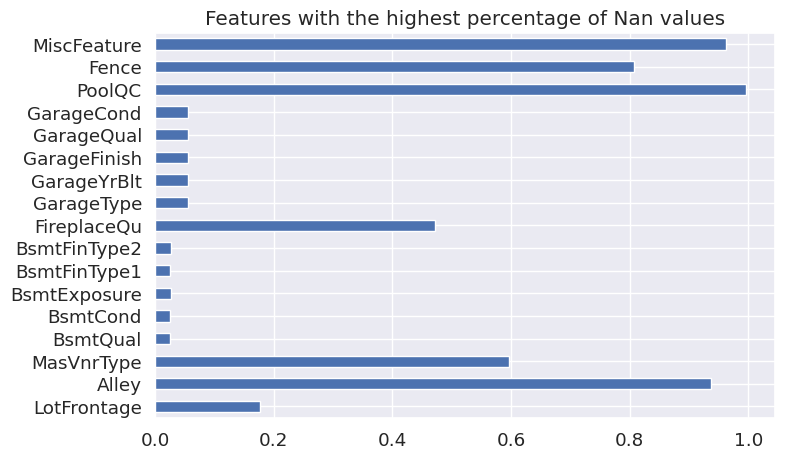

In [14]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

**Removing Id column**

In [15]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

**Removing columns that contain the same value in 100%**

In [16]:
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

 **Removing outliers**

Removing outliers is important step in data analysis. However, while removing outliers in ML we should be careful, because we do not know if there are not any outliers in test set.

I used two techniques: more and less rigorous for this data.

The first one was **Z-score method**. Z-scores are expressed in terms of standard deviations from their means. As a result, these z-scores have a distribution with a mean of 0 and a standard deviation of 1.  
I set **threshold = 3** to identify outliers.
$$ z = \frac{x - \mu}{\sigma} $$


In [17]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns

    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

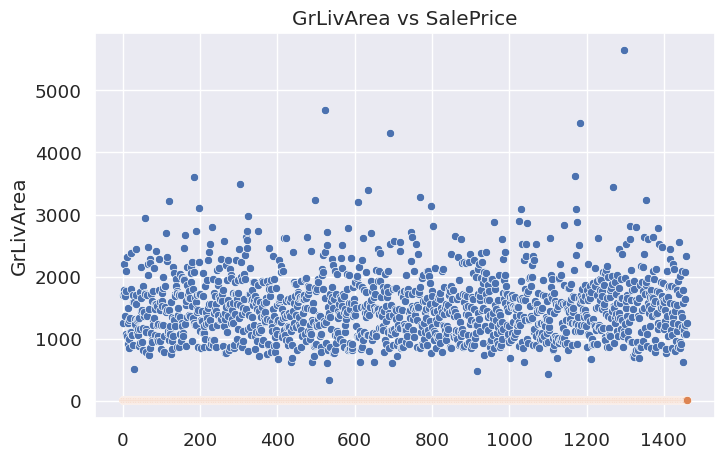

In [18]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(data_df["GrLivArea"])
sns.scatterplot(data_df["SalePrice"])
# plt.vlines(4500, ymax=800000, ymin=0)
plt.title("GrLivArea vs SalePrice")

In [19]:
# I decided to remove those records where 'GrLivArea' is more than 4500. We can see on plot that they have a vey low price.
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)

In [20]:
# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

**GarageYrBlt feature**

I checked if there are records that YearBuilt or GarageYrBlt have further year than 2017.

In [21]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [22]:
all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [23]:
all_data.loc[2590, 'GarageYrBlt'] = 2007

**LotFrontage feature**

LotFrontage is  a linear feet of street connected to property. I think it is a high probability that these values are similar to houses in the same Neighborhood. I check some statistics for them.

In [24]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [25]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**Transformation of some numerical variables that are actually categorical.**

In [26]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [27]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [28]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"]
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [29]:
# Generating numerical features as input to DataFrameMapper.
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'median',
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant],
                                               classes=[{'class': SimpleImputer,
                                                         'strategy': 'constant',
                                                         'fill_value' : 0,
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)


**Categorical to numeral**

There is a lot of categorical features in data, so the next step is to transform  them into numerical values.

In [30]:
# Selecting category features
cat_feats = all_data.select_dtypes(include=['object']).columns

According to data description (possible values for each feature) on Kaggle, I created a list of conversion values, specific for each column.

In [31]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"),
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"),
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"),
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","NA"),
                  ("GarageCond","NA"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("Functional","Typ"),
                  ("GarageType","No"),
                  ("GarageFinish","No"),
                  ("GarageQual","No"),
                  ("GarageCond","No"),
                  ("HeatingQC","TA"),
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"),
                  ("Exterior2nd", "VinylSd"),
                  ("SaleType", "WD")]

I implemented the none_transform function which converts missing categorical values into specific strings from the none_conversion dictionary.

In [32]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values
    into specific strings according to "conversion_list"

    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [33]:
# Applying the "none_transform" function
all_data = none_transform(all_data, none_conversion)

In [34]:
len(all_data.columns)

78

**Transformation of skewed features**

As for linear models preferable are normally distributed data, I am transforming the skewed features to make them more normally distributed.

In [35]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']]

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


I tried two method : Log-transformation and BoxCox transformation. As Box-Cox gave me little better results I decided to use it finally.

In [36]:
# Applying log-transformation
# all_data[skewed_features] = np.log1p(all_data[skewed_features])# test_df[skewed_features] = np.log1p(test_df[skewed_features])


A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

In [37]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

**Categorical into Numerical**


In [38]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}

    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d):
                return d

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

Some Neighborhood seems to be more expensive than the others so..:

In [39]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2,
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1,
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])


As I implemented previously specific transformers for categorical data, I will run the whole pipeline for them.

In [40]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual",
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [41]:
original_features_df.shape

(2919, 10)

In [42]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [43]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [44]:
all_data.shape

(2919, 78)

## Splitting into train/test

In [45]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


# Modelization
-----------------------------------

In [46]:
X_train = train_preprocessed

In [47]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [48]:
print('Environment specification:\n')
for mod in sklearn, xgb, lgb:
    print(mod.__name__, mod.__version__)

Environment specification:

sklearn 1.2.2
xgboost 2.0.3
lightgbm 4.1.0


**Defining scoring function**

In [49]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

**Linear Regression**

In [51]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns

# Handle non-numeric columns (example: fill missing values and one-hot encode)
X_train_encoded = pd.get_dummies(X_train, columns=non_numeric_cols, dummy_na=True)

# Create and fit the pipeline
lr_model = make_pipeline(RobustScaler(), LinearRegression())
lr_model.fit(X_train_encoded, y_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

In [55]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Example DataFrame with a mix of numerical and categorical data
# X_train = pd.DataFrame({
#     'feature1': [1, 2, 3, 4],
#     'feature2': ['A', 'B', 'A', 'B']
# })
# y_train = pd.Series([10, 15, 10, 20])

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create pipeline with preprocessor and linear regression model
lr_model = make_pipeline(preprocessor, LinearRegression())

# Fit the model
lr_model.fit(X_train, y_train)

# Predict and calculate MSE
y_train_pred = lr_model.predict(X_train)
MSE_train = mean_squared_error(y_train, y_train_pred)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(np.sqrt(MSE_train)))


Mean Squared Error = 0.00000128
RMSE score for Linear Regression: 0.001


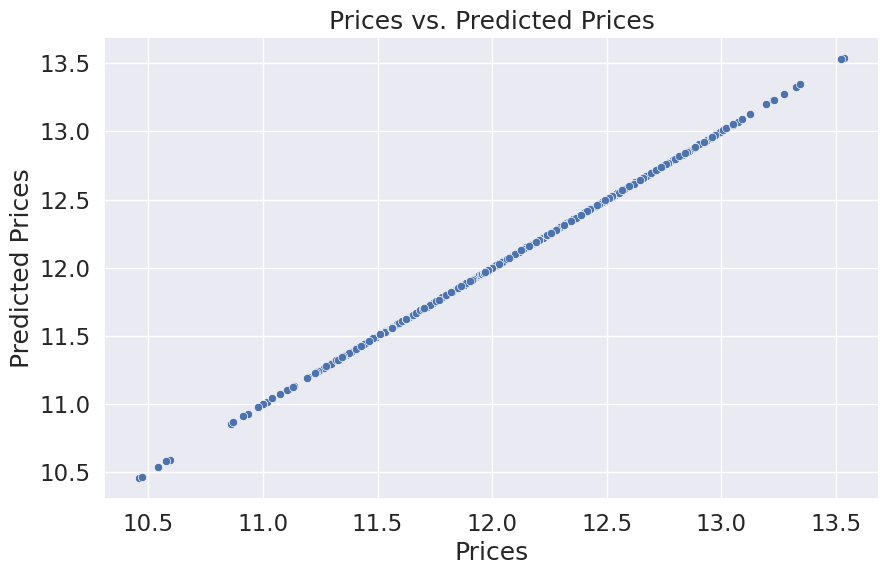

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted Prices")
plt.title("Prices vs. Predicted Prices")
plt.show()

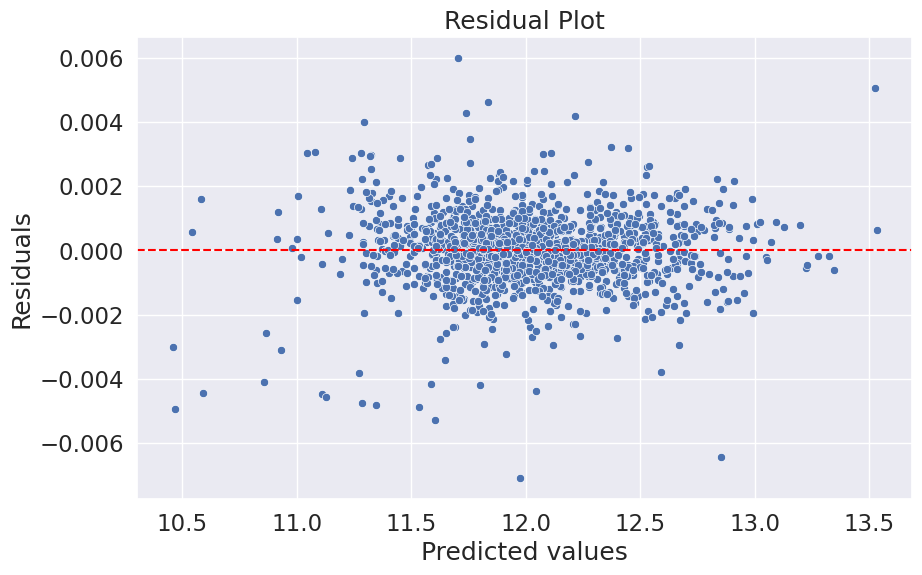

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_train_pred, y=y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.show()

**LASSO model**

In [62]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

# Example DataFrame with a mix of numerical and categorical data
# X_train = pd.DataFrame({
#     'feature1': [1, 2, 3, 4],
#     'feature2': ['A', 'B', 'A', 'B']
# })
# y_train = pd.Series([10, 15, 10, 20])

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create pipeline with preprocessor and Lasso model
lasso_model = make_pipeline(preprocessor,
                            LassoCV(alphas=[0.0004, 0.0005, 0.0006],
                                    random_state=0,
                                    cv=10))

# Fit the model
lasso_model.fit(X_train, y_train)

# Predict and calculate MSE
y_train_pred = lasso_model.predict(X_train)
MSE_train = mean_squared_error(y_train, y_train_pred)

# Print the best alpha (access the named steps in the pipeline)
best_alpha = lasso_model.named_steps['lassocv'].alpha_

print("Best alpha: {}".format(best_alpha))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(np.sqrt(MSE_train)))

Best alpha: 0.0004
Mean Squared Error = 0.00000026
RMSE score for LASSO: 0.001


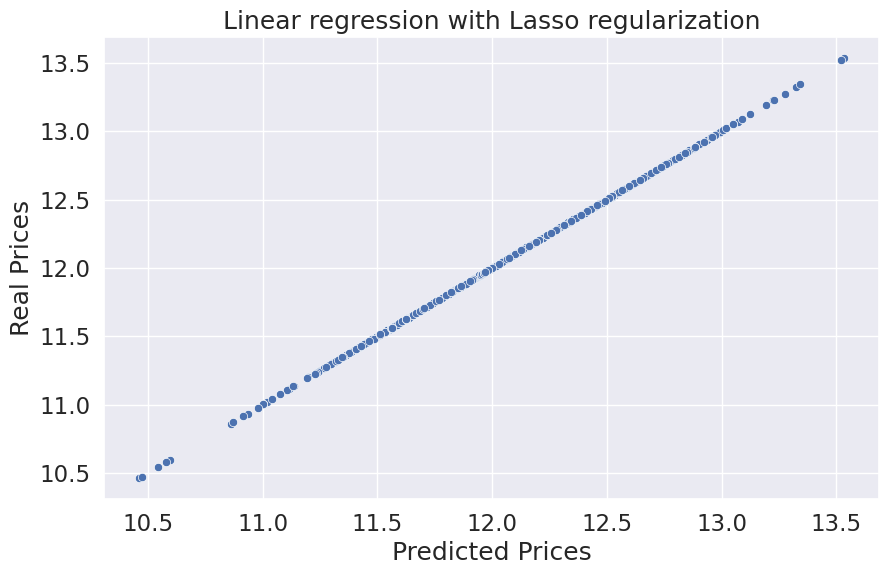

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting predictions
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_train_pred, y=y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real Prices")
plt.show()